In [46]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

In [47]:
#Cálculos de acerto
calculos_erro = []

#função para retorno estruturado dos erros
def calcula_erro(predicao, real, modelo):
  def symetric_mean_absolute_percentage_error(actual, predicted) -> float:
    if not all([isinstance(actual, np.ndarray),  
                isinstance(predicted, np.ndarray)]): 
        actual, predicted = np.array(actual), 
        np.array(predicted) 
  
    return round( 
        np.mean( 
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2) 
        )*100, 2
    )
  
  mae = mean_absolute_error(real, predicao)
  rmse = mean_squared_error(real, predicao)
  smape = symetric_mean_absolute_percentage_error(real, predicao)
  retorno = {
     'modelo': modelo,
     'mae': mae,
     'rmse': rmse,
     'smape %': smape
  }

  return retorno

In [48]:
#Processos da pipeline
class PrepareData(BaseEstimator, TransformerMixin):
    def __init__(self, feature_to_datatime='Data', feature_to_replace='Preço - petróleo bruto - Brent (FOB)'):
        self.feature_to_datatime = feature_to_datatime
        self.feature_to_replace = feature_to_replace
    
    def fit(self, df):
        return self
    
    def transform(self, df):
        df[self.feature_to_datatime] = pd.to_datetime(df[self.feature_to_datatime], format="%Y-%m-%d")
        df.set_index(self.feature_to_datatime, inplace=True)
        df[self.feature_to_replace] = df[self.feature_to_replace].astype(float)
        df.dropna(inplace=True)
        df.sort_index(inplace=True, ascending=False)
        return df

class FillNANValues(BaseEstimator, TransformerMixin):
    def __init__(self, feature_to_fill='Preço - petróleo bruto - Brent (FOB)'):
        self.feature_to_fill = feature_to_fill
    
    def fit(self, df):
        return self
    
    def transform(self, df):
        df.sort_index(inplace=True, ascending=False)
        start_date = df.index[len(df.index) -1]
        end_date = df.index[0]
        date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        df = df.reindex(date_range)
        media_movel = df[self.feature_to_fill].rolling(window=30, min_periods=1).mean()
        df[self.feature_to_fill] = df[self.feature_to_fill].combine_first(media_movel)
        df = df[self.feature_to_fill].dropna()
        df.columns = ['ds', 'y']
        return df

class SomthDataIntervalValues(BaseEstimator, TransformerMixin):
    def __init__(self):
       return
    
    def fit(self, df):
        return self
    
    def transform(self, df):
        df = np.log(df) #escala logarítmica
        ma_log = df.rolling(7).mean() #média móvel
        df = (df - ma_log).dropna() #diferenciação
        df = pd.DataFrame(df)
        df['MA'] = ma_log
        df.sort_index(inplace=True, ascending=False)
        return df

pipeline_normalize = Pipeline([
    ('data_prepator', PrepareData()),
    ('filler_nan_values', FillNANValues())
])

pipeline_arima = Pipeline([
    ('data_prepator', PrepareData()),
    ('filler_nan_values', FillNANValues()),
    ('smother_data_interval', SomthDataIntervalValues())
])

In [49]:
#criação das pipelines
def process_pipeline_seazonal_test(df):
    pipeline_normalize = Pipeline([
        ('data_prepator', PrepareData()),
        ('filler_nan_values', FillNANValues())
    ])
    df_pipeline = pipeline_normalize.fit_transform(df)
    return df_pipeline

def process_pipeline_arima(df):
    pipeline_arima = Pipeline([
        ('data_prepator', PrepareData()),
        ('filler_nan_values', FillNANValues()),
        ('smother_data_interval', SomthDataIntervalValues())
    ])
    df_pipeline = pipeline_arima.fit_transform(df)
    return df_pipeline

In [50]:
df_brent = pd.read_csv('basePetroleoBrent.csv')
df_brent.rename(columns={'ds': 'Data', 'y': 'Preço - petróleo bruto - Brent (FOB)'}, inplace=True)
df_brent

,Data,Preço - petróleo bruto - Brent (FOB)
0,2024-11-04,74.89
1,2024-11-01,73.63
2,2024-10-31,73.25
3,2024-10-30,73.21
4,2024-10-29,71.09
...,...,...
11287,1987-05-26,18.63
11288,1987-05-25,18.60
11289,1987-05-22,18.55
11290,1987-05-21,18.45


<Figure size 1000x600 with 0 Axes>

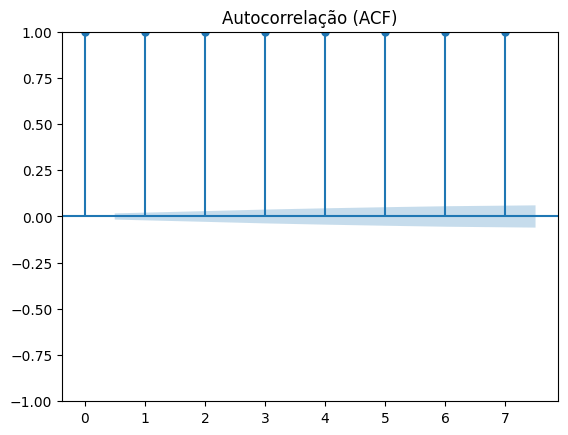

In [51]:
#validação de sazonalidade
series = process_pipeline_seazonal_test(df_brent.copy())

plt.figure(figsize=(10, 6))
plot_acf(series, lags=7)
plt.title("Autocorrelação (ACF)")
plt.show()

In [52]:
#Transformações dos dados com o proposito de estacionar os dados
df_arima_pipeline = process_pipeline_arima(df_brent.copy())[:365] #escala logarítmica
ma_arima_log = df_arima_pipeline['MA'] #média móvel
df_arima_s = df_arima_pipeline['Preço - petróleo bruto - Brent (FOB)'] #diferenciação
result = adfuller(df_arima_s.values)

#Validação do Adfuller
print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")
for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -5.944004357065843
P-Value: 2.2263475478285796e-07
Valores críticos:
	1%: -3.44880082033912
	5%: -2.869670179576637
	10%: -2.5711012838861036


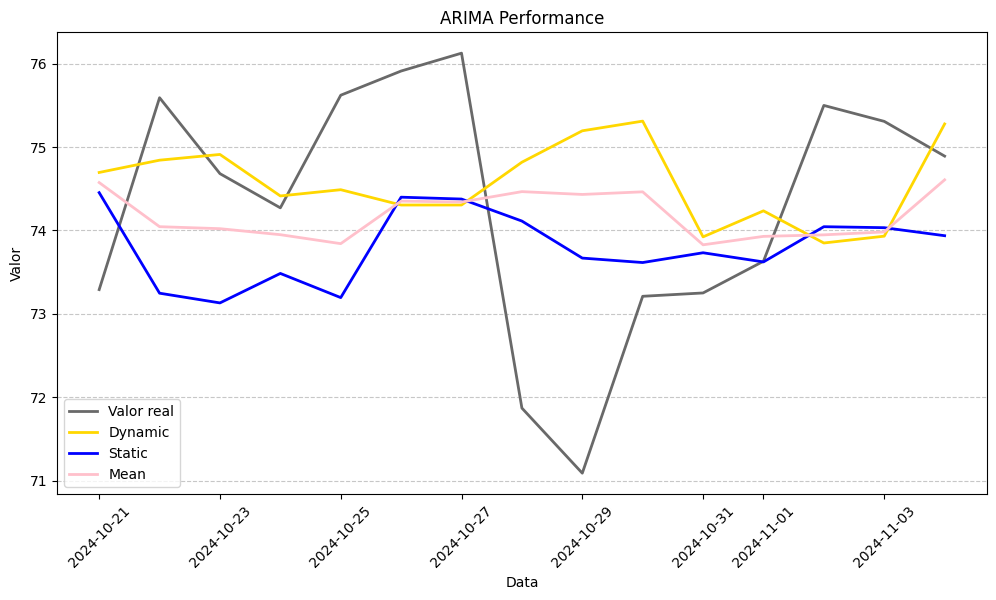

,ds,y
0,2024-11-04,74.605854
1,2024-11-03,73.981413
2,2024-11-02,73.946370
3,2024-11-01,73.927984
4,2024-10-31,73.826954
5,2024-10-30,74.462035
6,2024-10-29,74.430650
7,2024-10-28,74.464409
8,2024-10-27,74.339854
9,2024-10-26,74.350841


In [53]:
#ARIMA

#separando as bases de treino e teste
tam_previsao = 15
df_arima_s = df_arima_s.reset_index()
df_arima_s['unique_id'] = 'Brent'
df_arima_s.columns = ['ds', 'y', 'unique_id']
index_arima = df_arima_s['unique_id'].count() - tam_previsao
treino_arima = df_arima_s.tail(index_arima)
valid_arima = df_arima_s.head(tam_previsao)
h = valid_arima['ds'].nunique()

model_a = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1) #instância
model_a.fit(treino_arima) #treinamento

#Predições de teste
forecast_dfa = model_a.predict(h=h, level=[90])
forecast_dfa = forecast_dfa.reset_index().merge(valid_arima, on=['ds', 'unique_id'], how='left')
forecast_dfa.dropna(inplace=True)

#preparação dos dados para plotagem
valores_reais = process_pipeline_seazonal_test(df_brent.copy())[:-tam_previsao].iloc[-7:]
valores = pd.Series()
for prediction in forecast_dfa.values:
    df_log = np.log(valores_reais) #escala logarítmica
    ma_log = df_log.rolling(7).mean() #média móvel
    valor = np.exp(prediction[2] + ma_log.iloc[-1])
    valores_reais = valores_reais[1:]
    valores_reais = pd.concat([valores_reais, pd.Series([valor])])
    valores = pd.concat([valores, pd.Series([valor])])
dados_arima = valid_arima.merge(forecast_dfa)
dados_arima['data'] = dados_arima['ds']
dados_arima = dados_arima.set_index('ds')
dados_arima['y'] = np.exp(dados_arima['y'] + ma_arima_log)
dados_arima['AutoARIMA_result_static'] = np.exp(dados_arima['AutoARIMA'] + ma_arima_log.head(1).values[0])
dados_arima['AutoARIMA_result_dynamic'] = valores.values
dados_arima['AutoARIMA_result_mean'] = (dados_arima['AutoARIMA_result_dynamic'].values + dados_arima['AutoARIMA_result_static'].values)/2

#salva dados de previsão para uso do tensorflow
previsao_arima = pd.DataFrame(dados_arima['AutoARIMA_result_mean'].reset_index())
previsao_arima.rename(columns={'AutoARIMA_result_mean': 'y'}, inplace=True)

#calculo de erro com base na função criada
calculos_erro.append(calcula_erro(dados_arima['y'].values, dados_arima['AutoARIMA_result_dynamic'].values, 'AutoARIMA Dynamic - Média movél (15 dias)'))
calculos_erro.append(calcula_erro(dados_arima['y'].values, dados_arima['AutoARIMA_result_static'].values, 'AutoARIMA Static - Média movél (15 dias)'))
calculos_erro.append(calcula_erro(dados_arima['y'].values, dados_arima['AutoARIMA_result_mean'].values, 'AutoARIMA Mean - Média movél (15 dias)'))

#Configuração da plotagem dos dados
plt.figure(figsize=(12, 6))
sns.lineplot(x='data', y='y', data=dados_arima, label='Valor real', color='dimgray', linewidth=2)
sns.lineplot(x='data', y='AutoARIMA_result_dynamic', data=dados_arima, label='Dynamic', color='gold', linewidth=2)
sns.lineplot(x='data', y='AutoARIMA_result_static', data=dados_arima, label='Static', color='blue', linewidth=2)
sns.lineplot(x='data', y='AutoARIMA_result_mean', data=dados_arima, label='Mean', color='pink', linewidth=2)
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('ARIMA Performance')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
previsao_arima

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5496
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3437 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1278 
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1309 
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0854 
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0991 
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0812 
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0873 
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0838 
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0766 
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0792 
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0788 
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0810 
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0783 
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0757 
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━

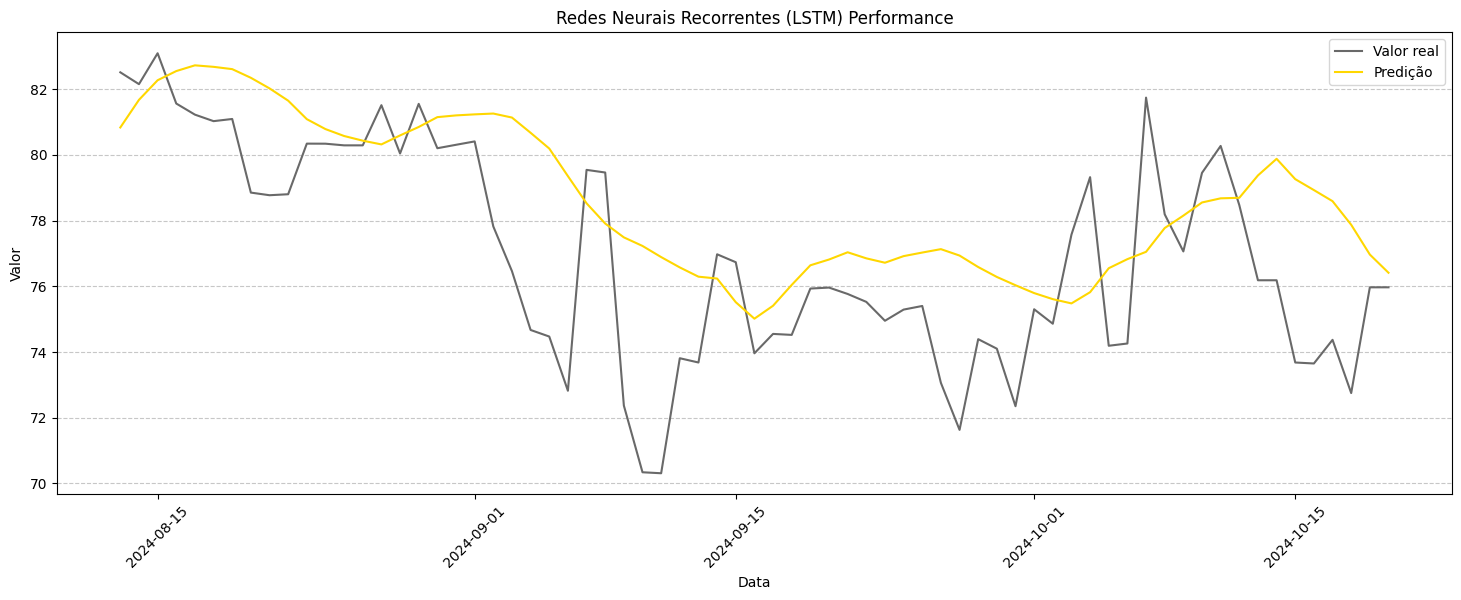

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


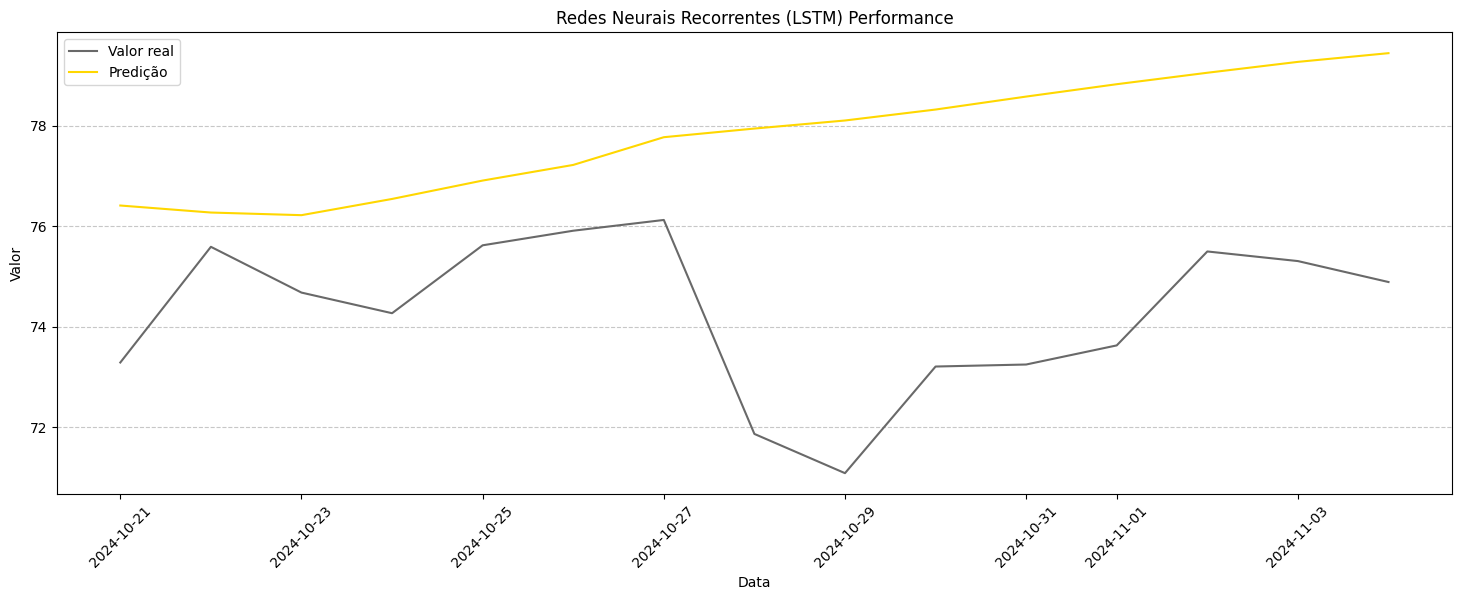

In [54]:
#Redes Neurais Recorrentes (LMST)
df_tensorflow = process_pipeline_seazonal_test(df_brent.copy()).tail(365)
df_tensorflow = pd.DataFrame(df_tensorflow)
df_tensorflow.reset_index(inplace=True)
df_tensorflow.columns = ['ds', 'y']
df_tensorflow['ds'] = pd.to_datetime(df_tensorflow['ds'])

# Ordenar por data
df_tensorflow = df_tensorflow.sort_values('ds')

# Resetar o índice
df_tensorflow.reset_index(drop=True, inplace=True)

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_tensorflow[['y']])

# Função para criar sequências de dados
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Definir o tamanho da sequência
seq_length = 7
tam_previsao = 15

# Criar sequências de treino
X, y = create_sequences(scaled_data[:-tam_previsao], seq_length)

# Dividir em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Construir o modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_absolute_error')

# Treinar o modelo
model.fit(X_train, y_train, epochs=20, batch_size=64)

# Fazer predições
predicted_prices = model.predict(X_test)

# Desnormalizar os dados
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test = scaler.inverse_transform(y_test)

#Configuração de plotagem dos dados
plt.figure(figsize=(18, 6))
plt.plot(df_tensorflow.iloc[:-tam_previsao]['ds'][-len(y_test):], y_test, color='dimgray', label='Valor real')
plt.plot(df_tensorflow.iloc[:-tam_previsao]['ds'][-len(y_test):], predicted_prices, color='gold', label='Predição')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Redes Neurais Recorrentes (LSTM) Performance')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Validação

janela_valores = X_test[-1].reshape(1, seq_length, 1)
# Fazer predições
dias_previsao = tam_previsao
previsoes = np.array([])
for i in range(0, dias_previsao):
    predicted_prices = model.predict(janela_valores)
    previsao_desnormalizada = scaler.inverse_transform(predicted_prices)
    previsoes = np.append(previsoes, np.array(previsao_desnormalizada))
    janela_valores = np.append(janela_valores[0, 1:], np.array(predicted_prices))
    janela_valores = janela_valores.reshape(1, seq_length, 1)

calculos_erro.append(calcula_erro(df_tensorflow[-tam_previsao:]['y'].values, previsoes, 'LSTM - Real (15 dias)'))

#Configuração de plotagem dos dados
plt.figure(figsize=(18, 6))
plt.plot(df_tensorflow.iloc[-tam_previsao:]['ds'], df_tensorflow[-tam_previsao:]['y'], color='dimgray', label='Valor real')
plt.plot(df_tensorflow.iloc[-tam_previsao:]['ds'], previsoes, color='gold', label='Predição')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Redes Neurais Recorrentes (LSTM) Performance')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2313
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0816 
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0496 
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0458 
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0434 
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0444 
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0424 
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0456 
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0431 
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0442 
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0438 
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0434 
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0431 
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0446 
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0438 
Epoch

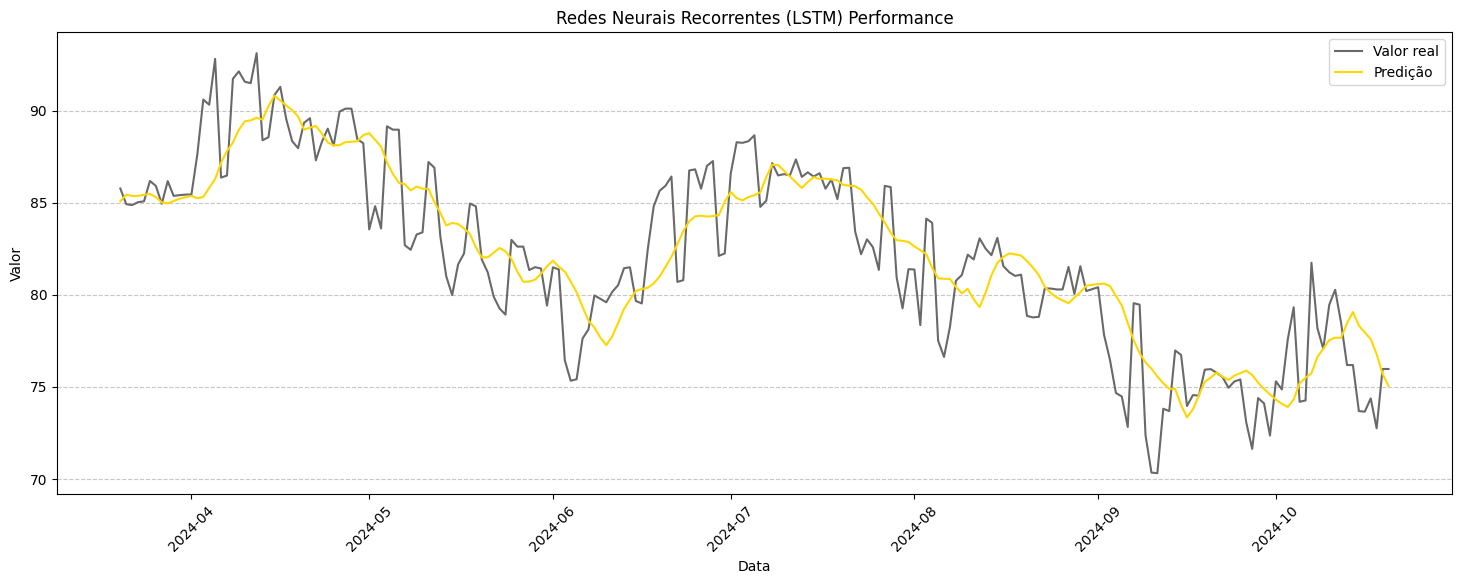

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


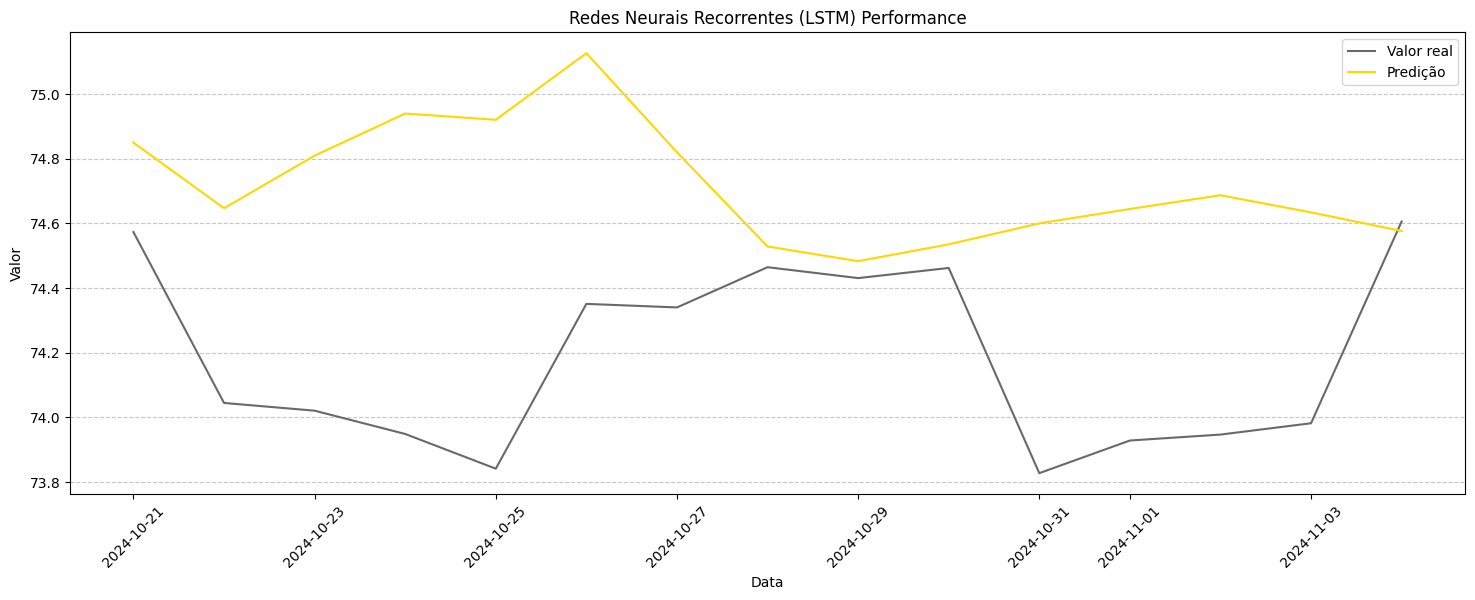

In [55]:
#Redes Neurais Recorrentes (LMST)
df_tensorflow_arima = process_pipeline_seazonal_test(df_brent.copy()).tail(1095)
df_tensorflow_arima = pd.DataFrame(df_tensorflow_arima)
df_tensorflow_arima.reset_index(inplace=True)
df_tensorflow_arima.columns = ['ds', 'y']
df_arima_tf = pd.concat([df_tensorflow_arima.copy()[['ds', 'y']].iloc[:-15], previsao_arima], axis=0)
df_tensorflow = df_arima_tf.copy()
df_tensorflow['ds'] = pd.to_datetime(df_tensorflow['ds'])

# Ordenar por data
df_tensorflow = df_tensorflow.sort_values('ds')

# Resetar o índice
df_tensorflow.reset_index(drop=True, inplace=True)

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_tensorflow[['y']])

# Função para criar sequências de dados
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Definir o tamanho da sequência
seq_length = 7
tam_previsao = 15

# Criar sequências de treino
X, y = create_sequences(scaled_data, seq_length)

# Dividir em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X[:-tam_previsao], y[:-tam_previsao], test_size=0.2, shuffle=False)

# Construir o modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_absolute_error')

# Treinar o modelo
model.fit(X_train, y_train, epochs=20, batch_size=64)

# Fazer predições
predicted_prices = model.predict(X_test)

# Desnormalizar os dados
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test = scaler.inverse_transform(y_test)

#Configuração de plotagem dos dados
plt.figure(figsize=(18, 6))
plt.plot(df_tensorflow.iloc[:-tam_previsao]['ds'][-len(y_test):], y_test, color='dimgray', label='Valor real')
plt.plot(df_tensorflow.iloc[:-tam_previsao]['ds'][-len(y_test):], predicted_prices, color='gold', label='Predição')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Redes Neurais Recorrentes (LSTM) Performance')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Validação
# Fazer predições
previsoes = model.predict(X[-tam_previsao:])
previsoes = scaler.inverse_transform(previsoes)

calculos_erro.append(calcula_erro(df_tensorflow[-tam_previsao:]['y'].values, previsoes, 'LSTM + ARIMA - Real (15 dias)'))

#Configuração de plotagem dos dados
plt.figure(figsize=(18, 6))
plt.plot(df_tensorflow.iloc[-tam_previsao:]['ds'], df_tensorflow[-tam_previsao:]['y'], color='dimgray', label='Valor real')
plt.plot(df_tensorflow.iloc[-tam_previsao:]['ds'], previsoes, color='gold', label='Predição')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Redes Neurais Recorrentes (LSTM) Performance')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [56]:
#Conversão da tabela de erros para um dataframe e apresentação
df_erros = pd.DataFrame(calculos_erro)
df_erros

,modelo,mae,rmse,smape %
0,AutoARIMA Dynamic - Média movél (15 dias),1.394724,3.019235,1.88
1,AutoARIMA Static - Média movél (15 dias),1.394852,2.519988,1.88
2,AutoARIMA Mean - Média movél (15 dias),1.343684,2.498479,1.81
3,LSTM - Real (15 dias),3.508534,16.018503,4.62
4,LSTM + ARIMA - Real (15 dias),0.539900,0.409574,0.73
